# Data exploration

In [72]:
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm
from collections import Counter

from gensim import corpora, models
#import nltk
from nltk.corpus import stopwords
# word cloud
from wordcloud import WordCloud

Load the data

In [3]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)
print(f"Number of samples: {len(df)}")
print(f"Columns: {[col for col in df.columns]}")
df.head()

Number of samples: 6807
Columns: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels']


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [4]:
# print all length and all unique labels
lables_list = np.concatenate(df['labels'].values)
unique_labels = set(lables_list)
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Unique labels:")
for label in unique_labels:
    print(f"  {label}")

Number of unique labels: 13
Unique labels:
  I-NAME_STUDENT
  I-STREET_ADDRESS
  B-USERNAME
  B-PHONE_NUM
  B-NAME_STUDENT
  B-EMAIL
  B-URL_PERSONAL
  O
  I-ID_NUM
  I-PHONE_NUM
  B-STREET_ADDRESS
  I-URL_PERSONAL
  B-ID_NUM


Note: not all labels consist of the full BIO format - i.e. missing the I

In [35]:
# Prepare labels
labels = [
    "B-EMAIL", 
    "B-ID_NUM", "I-ID_NUM",
    "B-NAME_STUDENT", "I-NAME_STUDENT",
    "B-PHONE_NUM", "I-PHONE_NUM",
    "B-STREET_ADDRESS", "I-STREET_ADDRESS",
    "B-URL_PERSONAL", "I-URL_PERSONAL",
    "B-USERNAME",
    "O"]
print(len(labels))
labels_not_bio = list(set([label[2:] if label != "O" else 'O' for label in labels]))
# make O come last
labels_not_bio.remove('O')
labels_not_bio.append('O')
print(len(labels_not_bio))
# BIO format to not BIO format label mapping
bio2notbio = {label: label[2:] if label != "O" else 'O' for label in labels}
notbio2bio = {label: [] for label in labels_not_bio}
for key, value in bio2notbio.items():
    notbio2bio[value].append(key)

# id conversion
id2label = dict(enumerate(labels)) 
label2id = {v:k for k,v in id2label.items()}

# other
num_labels = len(labels)

13
8


In [34]:
# create dictionaries for data analysis
label_2_word_list = {label: [] for label in labels}
label_2_word_lengths = {label: [] for label in labels}
label_2_norm_positions = {label: [] for label in labels}
for i, row in tqdm(df.iterrows(), total=len(df)):
    n_tokens = len(row['tokens'])
    for i_token, (token, label) in enumerate(zip(row['tokens'], row['labels'])):
        label_2_word_list[label].append(token)
        label_2_word_lengths[label].append(len(token))
        label_2_norm_positions[label].append(i_token / n_tokens)

def data2notbio(data_dict, bio2notbio):
    # convert data from BIO format to not BIO format
    new_data = {val: [] for val in bio2notbio.values()}
    for key, value in data_dict.items():
        new_key = bio2notbio[key]
        new_data[new_key].extend(data_dict[key])
    return new_data

100%|██████████| 6807/6807 [00:02<00:00, 2559.74it/s]


---

## General data overview

#### Distribution of text lengths

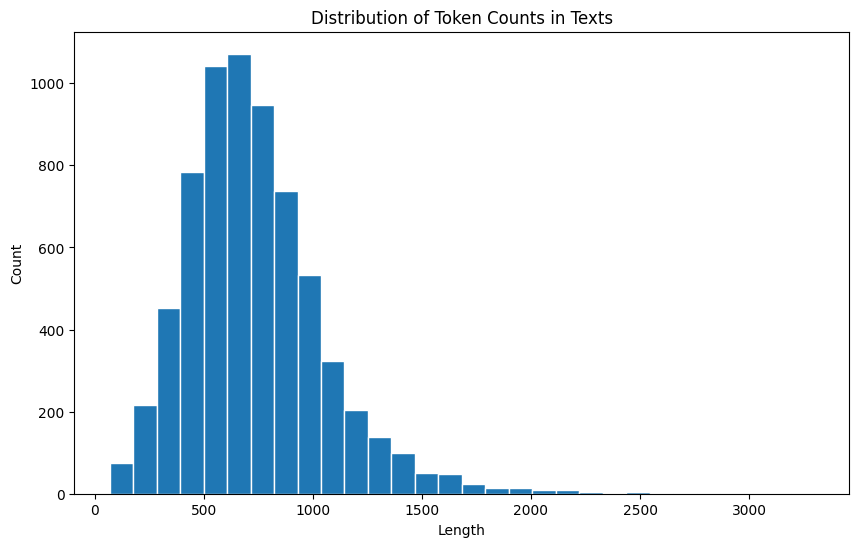

In [7]:
# Plot lengths
plt.figure(figsize=(10, 6))
lengths = df['tokens'].apply(len)
# add bin space
plt.hist(lengths, bins=30, edgecolor='white')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Token Counts in Texts")
plt.show()

Note:
- Generally the text follow a normal distribution, however with a right tail.
- Probably due to the nature of the texts being student texts with restrictions.

In [8]:
# TODO: some more general text analysis

---

## Class imbalance

#### Label occurence

In [9]:
# Initialize empty arrays
words = np.empty(len(data), dtype=object)
labels = np.empty(len(data), dtype=object)

# Fill the arrays
for i, x in tqdm(enumerate(data), total=len(data)):
    words[i] = np.array(x["tokens"])
    labels[i] = np.array([label2id[label] for label in x["labels"]])

# Get useful lists
lables_list = np.concatenate(df['labels'].values)
unique_labels, label_counts = np.unique(lables_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]

100%|██████████| 6807/6807 [00:01<00:00, 4692.92it/s]


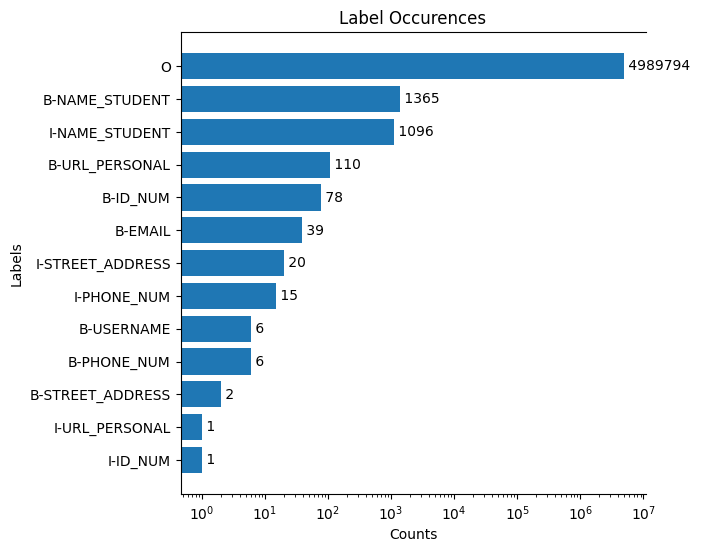

In [10]:
# plot a histogram of label occurences, labels on y-axis
plt.figure(figsize=(6, 6))
plt.barh(unique_labels, label_counts)
plt.xscale("log")
for i, count in enumerate(label_counts):
    plt.text(count, i, f" {count} ", va='center')
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title('Label Occurences')
plt.gca().spines['right'].set_visible(False)
plt.show()

Note:
- The data is heavily skewed with 'Name' being the most occurring label.

#### Label occurence - removing the BIO format

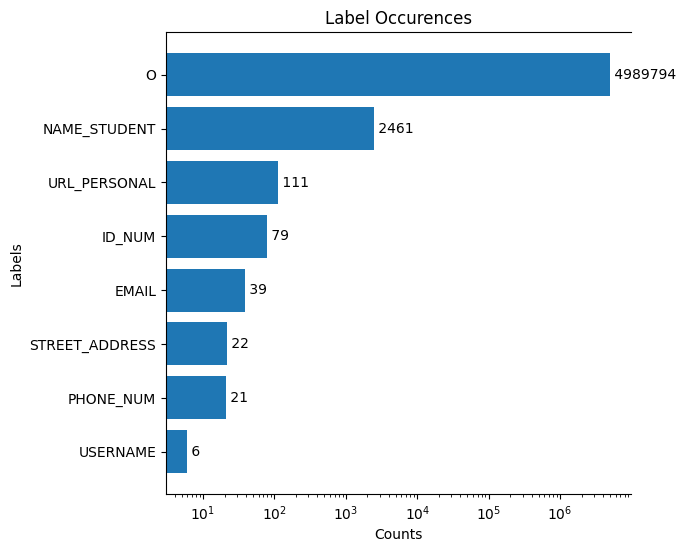

In [11]:
new_labels_list = [label[2:] if label != 'O' else label for label in lables_list]
unique_labels, label_counts = np.unique(new_labels_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]
# plot
plt.figure(figsize=(6, 6))
plt.barh(unique_labels, label_counts)
plt.xscale("log")
for i, count in enumerate(label_counts):
    plt.text(count, i, f" {count} ", va='center')
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title('Label Occurences')
plt.gca().spines['right'].set_visible(False)
plt.show()

Note:
- Very low counts for most of the labels

---

## Positional occurence

#### PII tag positional occurence

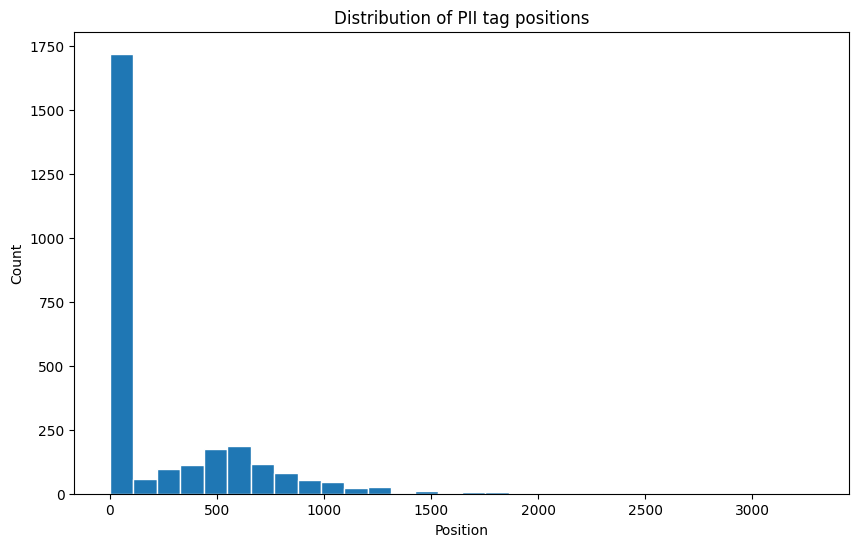

In [12]:
# Positions of PII
pos = np.concatenate([[i for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
# Plot lengths
plt.figure(figsize=(10, 6))
plt.hist(pos, bins=30, edgecolor='white')
plt.xlabel("Position")
plt.ylabel("Count")
plt.title("Distribution of PII tag positions")
plt.show()

Notes:
- Generally the PII tags are at the start of the text 
- The rest seem to follow the same distribution as the length of the texts - probably occuring at the end of the texts then

#### PII tag positional occurence in percentage

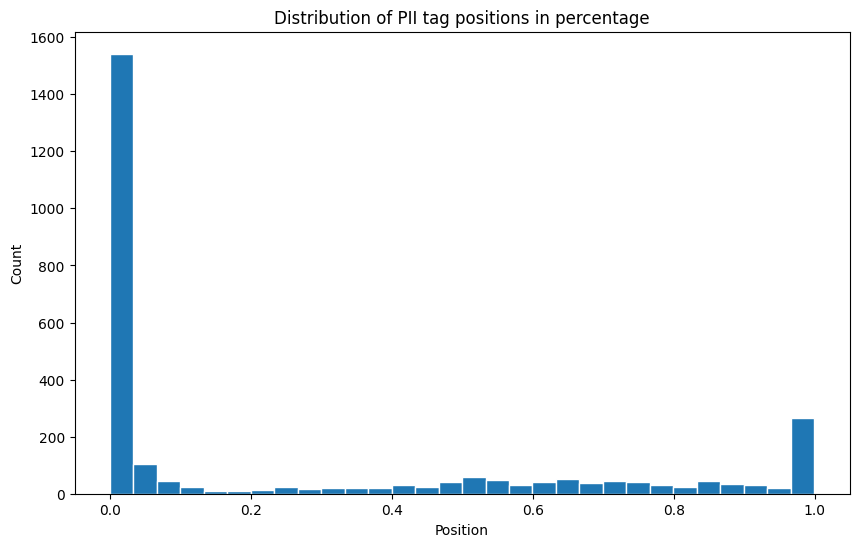

In [13]:
percentage_pos = np.concatenate([[i / len(entry)  for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
# Plot lengths
plt.figure(figsize=(10, 6))
plt.hist(percentage_pos, bins=30, edgecolor='white')
plt.xlabel("Position")
plt.ylabel("Count")
plt.title("Distribution of PII tag positions in percentage")
plt.show()

Note:
- As expected, the positional occurence in percentage indicated that:
    - PII mostly occurrs at the start and end of each student text.

#### Token position for each BIO label in text

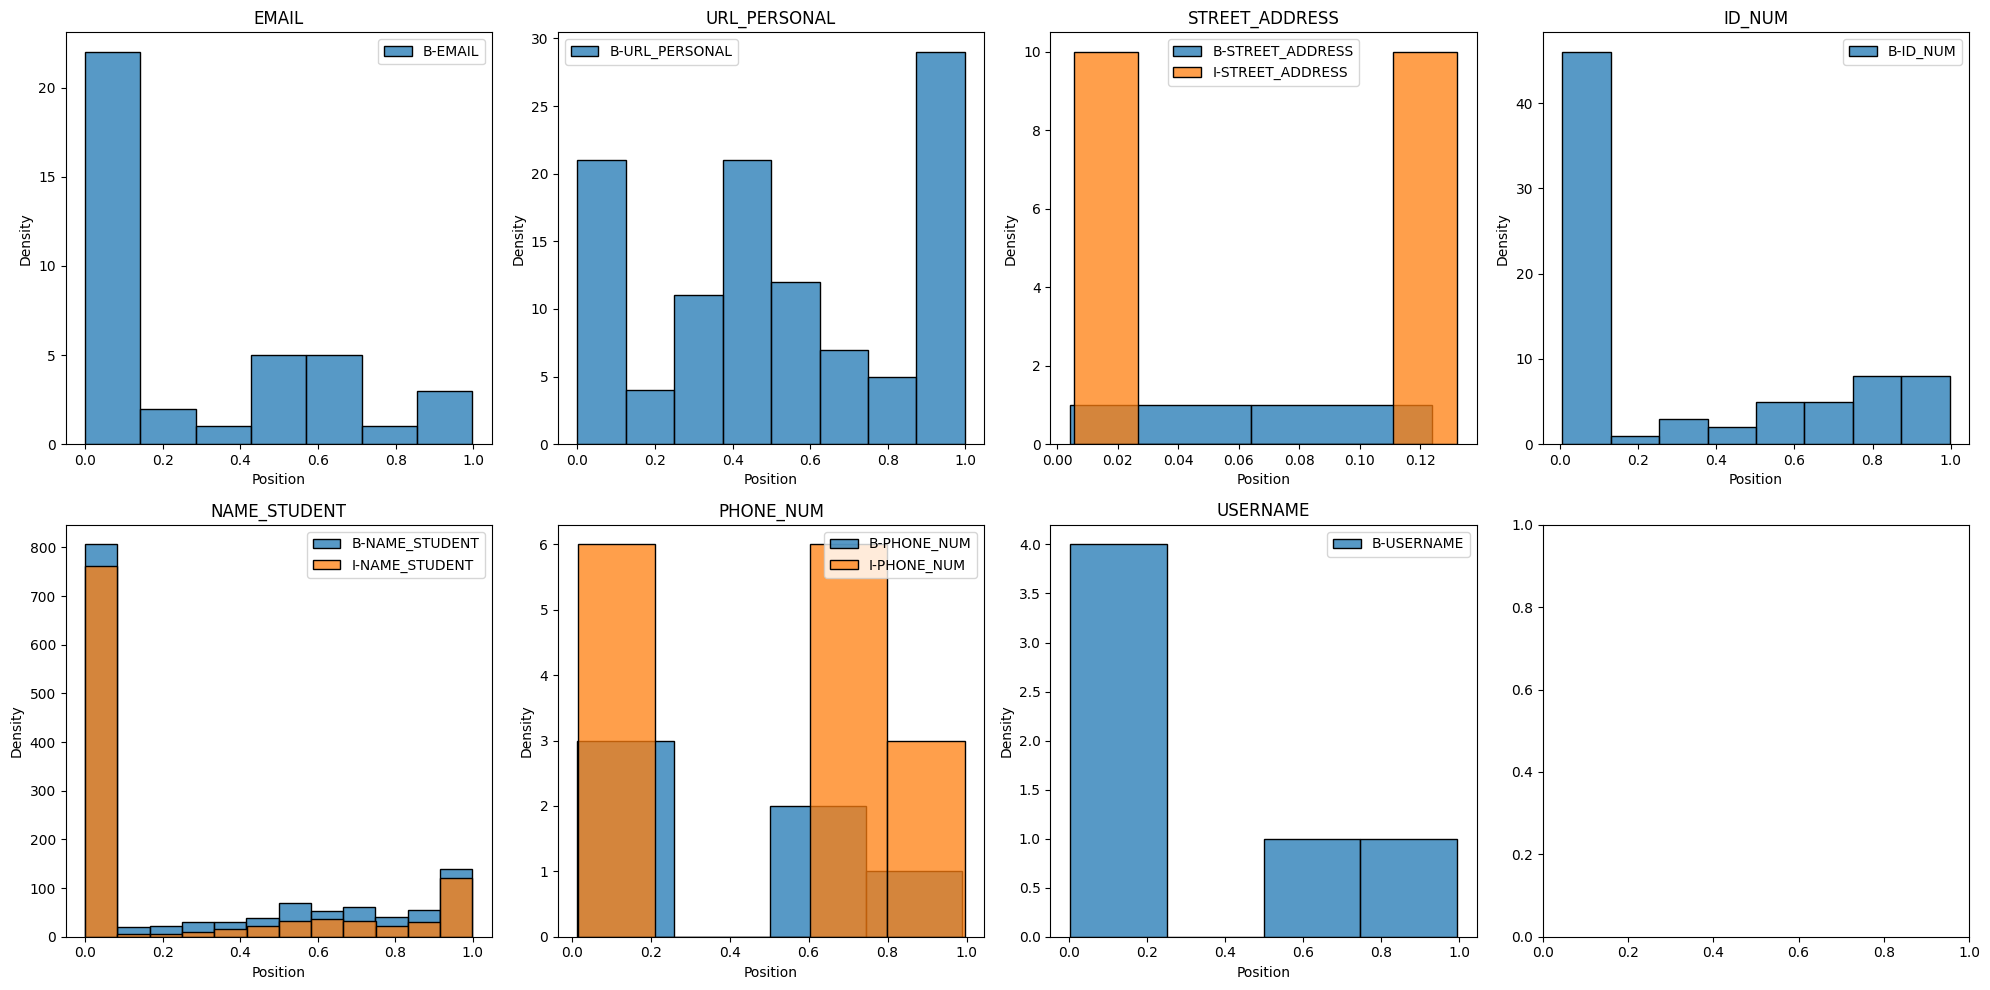

In [17]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, label in enumerate(labels_not_bio):
    if label != 'O':
        for bio_label in notbio2bio[label]:
            if len(label_2_norm_positions[bio_label]) > 1:
                #sns.kdeplot(label_2_norm_positions[bio_label], label=bio_label, ax=axs[i], fill=True, warn_singular=False)
                sns.histplot(label_2_norm_positions[bio_label], label=bio_label, ax=axs[i], kde=False)
        axs[i].legend()
        axs[i].set_title(label)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Density")    
plt.tight_layout()
plt.show()

Note:
- In general the data seems to have a tendency for two modes at the start and end of texts.
    - except URL_PERSONAL which also has a mode in the middle.
- EMAIL, NAME_STUDENT and ID_NUM all strongly favor the start.

#### Token position for each label in text

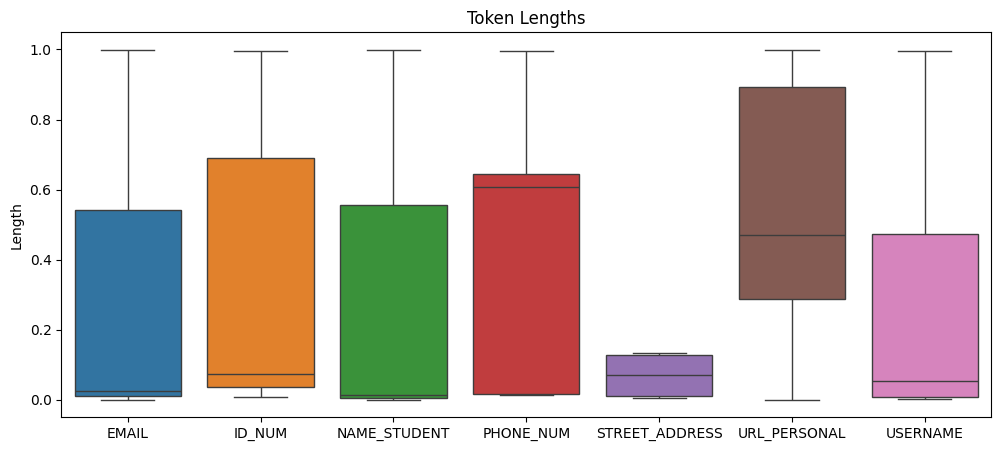

In [36]:
# boxplots
plt.figure(figsize=(12, 5))
data = data2notbio(label_2_norm_positions, bio2notbio)
# but ignore 'O'
data.pop('O')
sns.boxplot(data=data)
plt.title("Token Lengths")
plt.ylabel("Length")
plt.show()

Note:
- STREET_ADDRESS generally favors the start without much variation, and URL_PERSONAL the middle and end.
- All the other seem to have the same distribution.

---

## Label lengths

#### For each BIO label

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


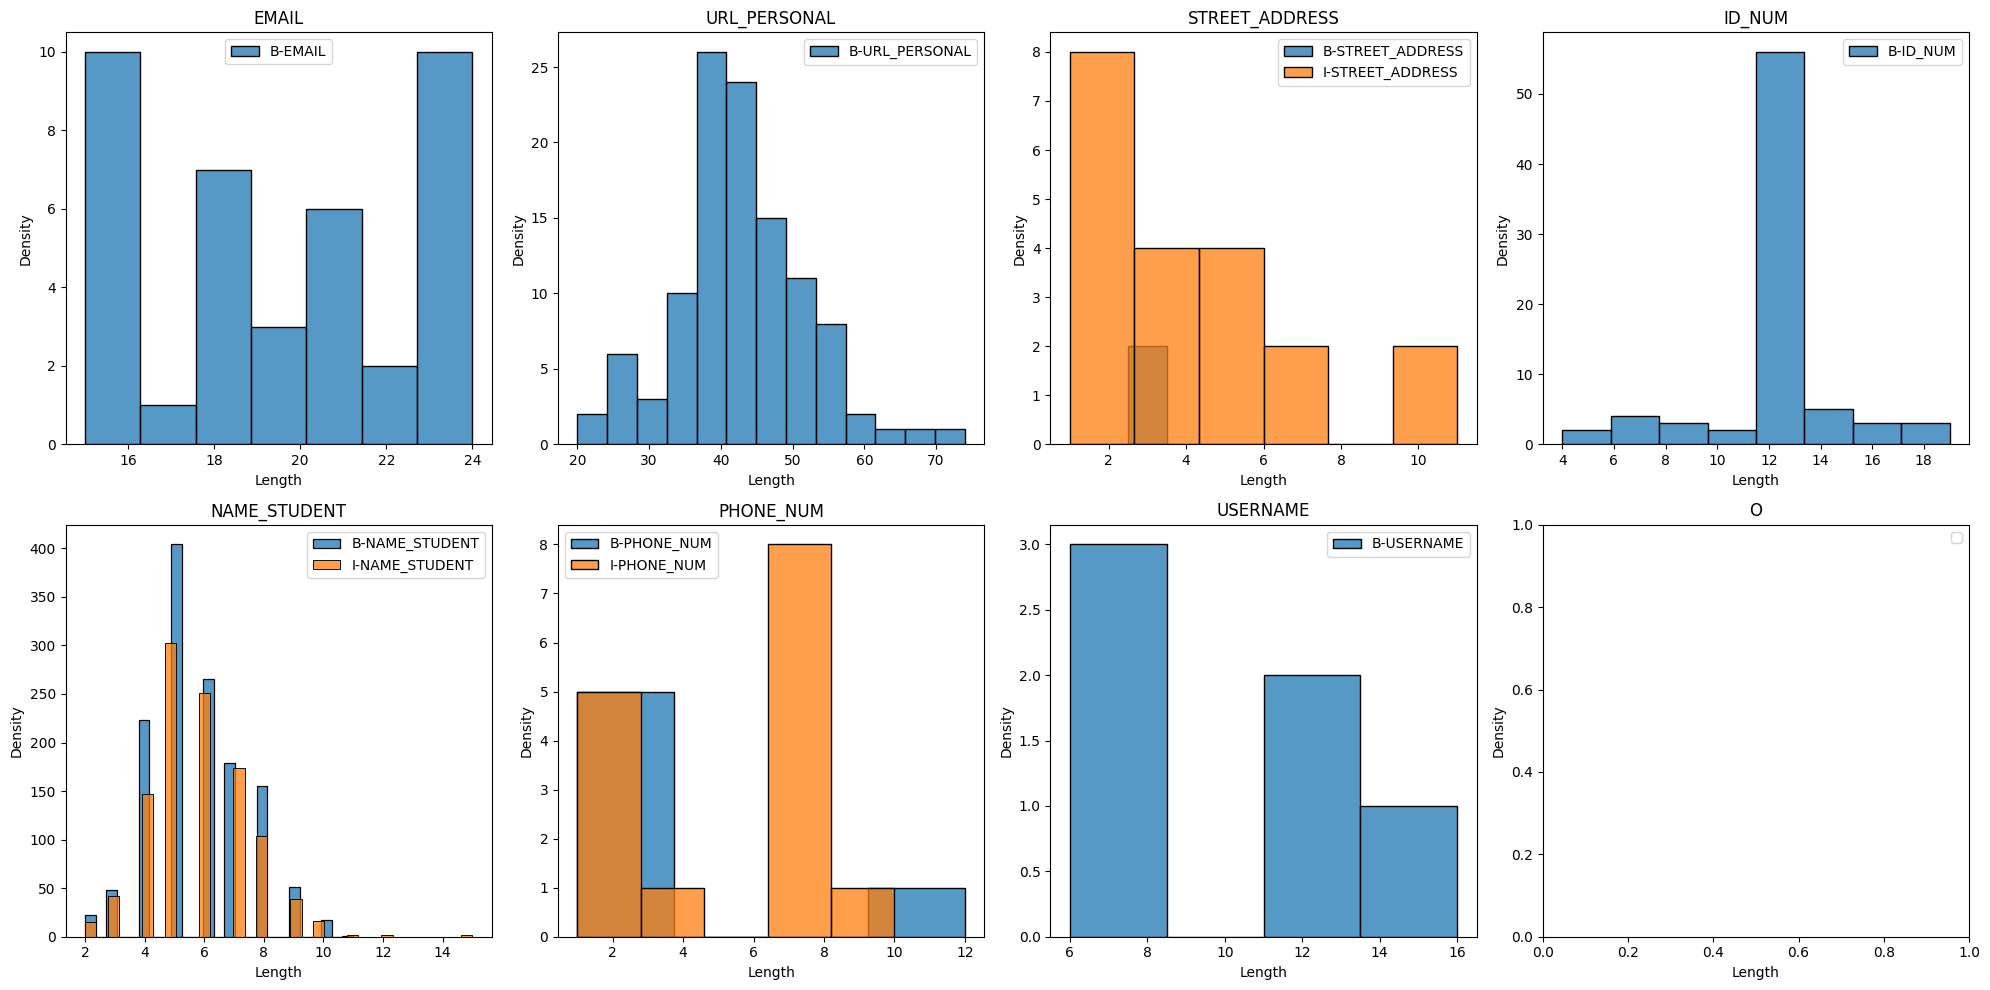

In [37]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, label in enumerate(labels_not_bio):
    if label != 'O':
        for bio_label in notbio2bio[label]:
            if len(label_2_norm_positions[bio_label]) > 1:
                #sns.kdeplot(label_2_norm_positions[bio_label], label=bio_label, ax=axs[i], fill=True, warn_singular=False)
                sns.histplot(label_2_word_lengths[bio_label], label=bio_label, ax=axs[i], kde=False)
    axs[i].legend();
    axs[i].set_title(label)
    axs[i].set_xlabel("Length")
    axs[i].set_ylabel("Density")    
plt.tight_layout()
plt.show()

Note:
- There is a clear difference in the distributions of each label.
- Both B and I NAME_STUDENT are almost identical
    - but for the PHONE_NUM there is a difference, probably due to phone number prefixes.
- ID_NUM seems to favor a length of 12.

#### For each label - joined BIO

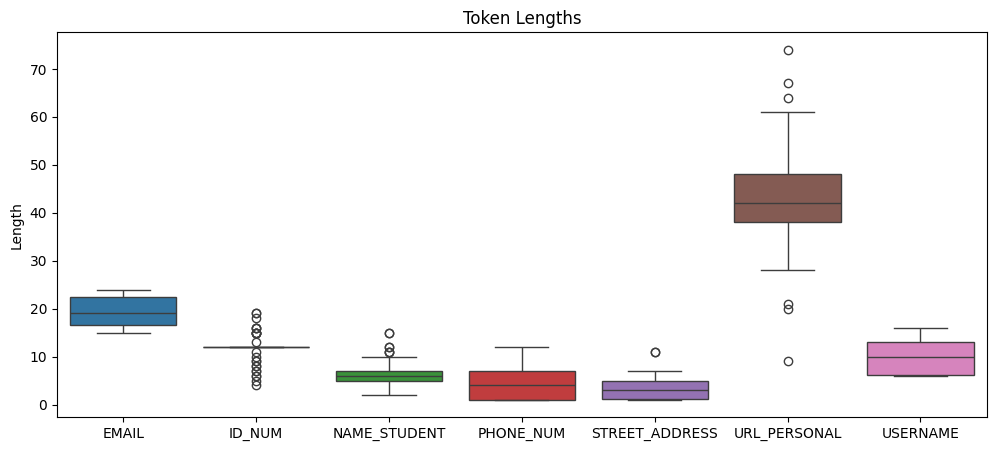

In [38]:
# boxplots
plt.figure(figsize=(12, 5))
data = data2notbio(label_2_word_lengths, bio2notbio)
# but ignore 'O'
data.pop('O')
sns.boxplot(data=data)
plt.title("Token Lengths")
plt.ylabel("Length")
plt.show()



Note:
- By joining each interclass BIO, the differences become even more apparent.
- Especially how ID_NUM seems very fixed.
- And that EMAIL and URL_PERSONAL are generally longer.

---

## Word frequencies for each label

#### Word cloud for each label

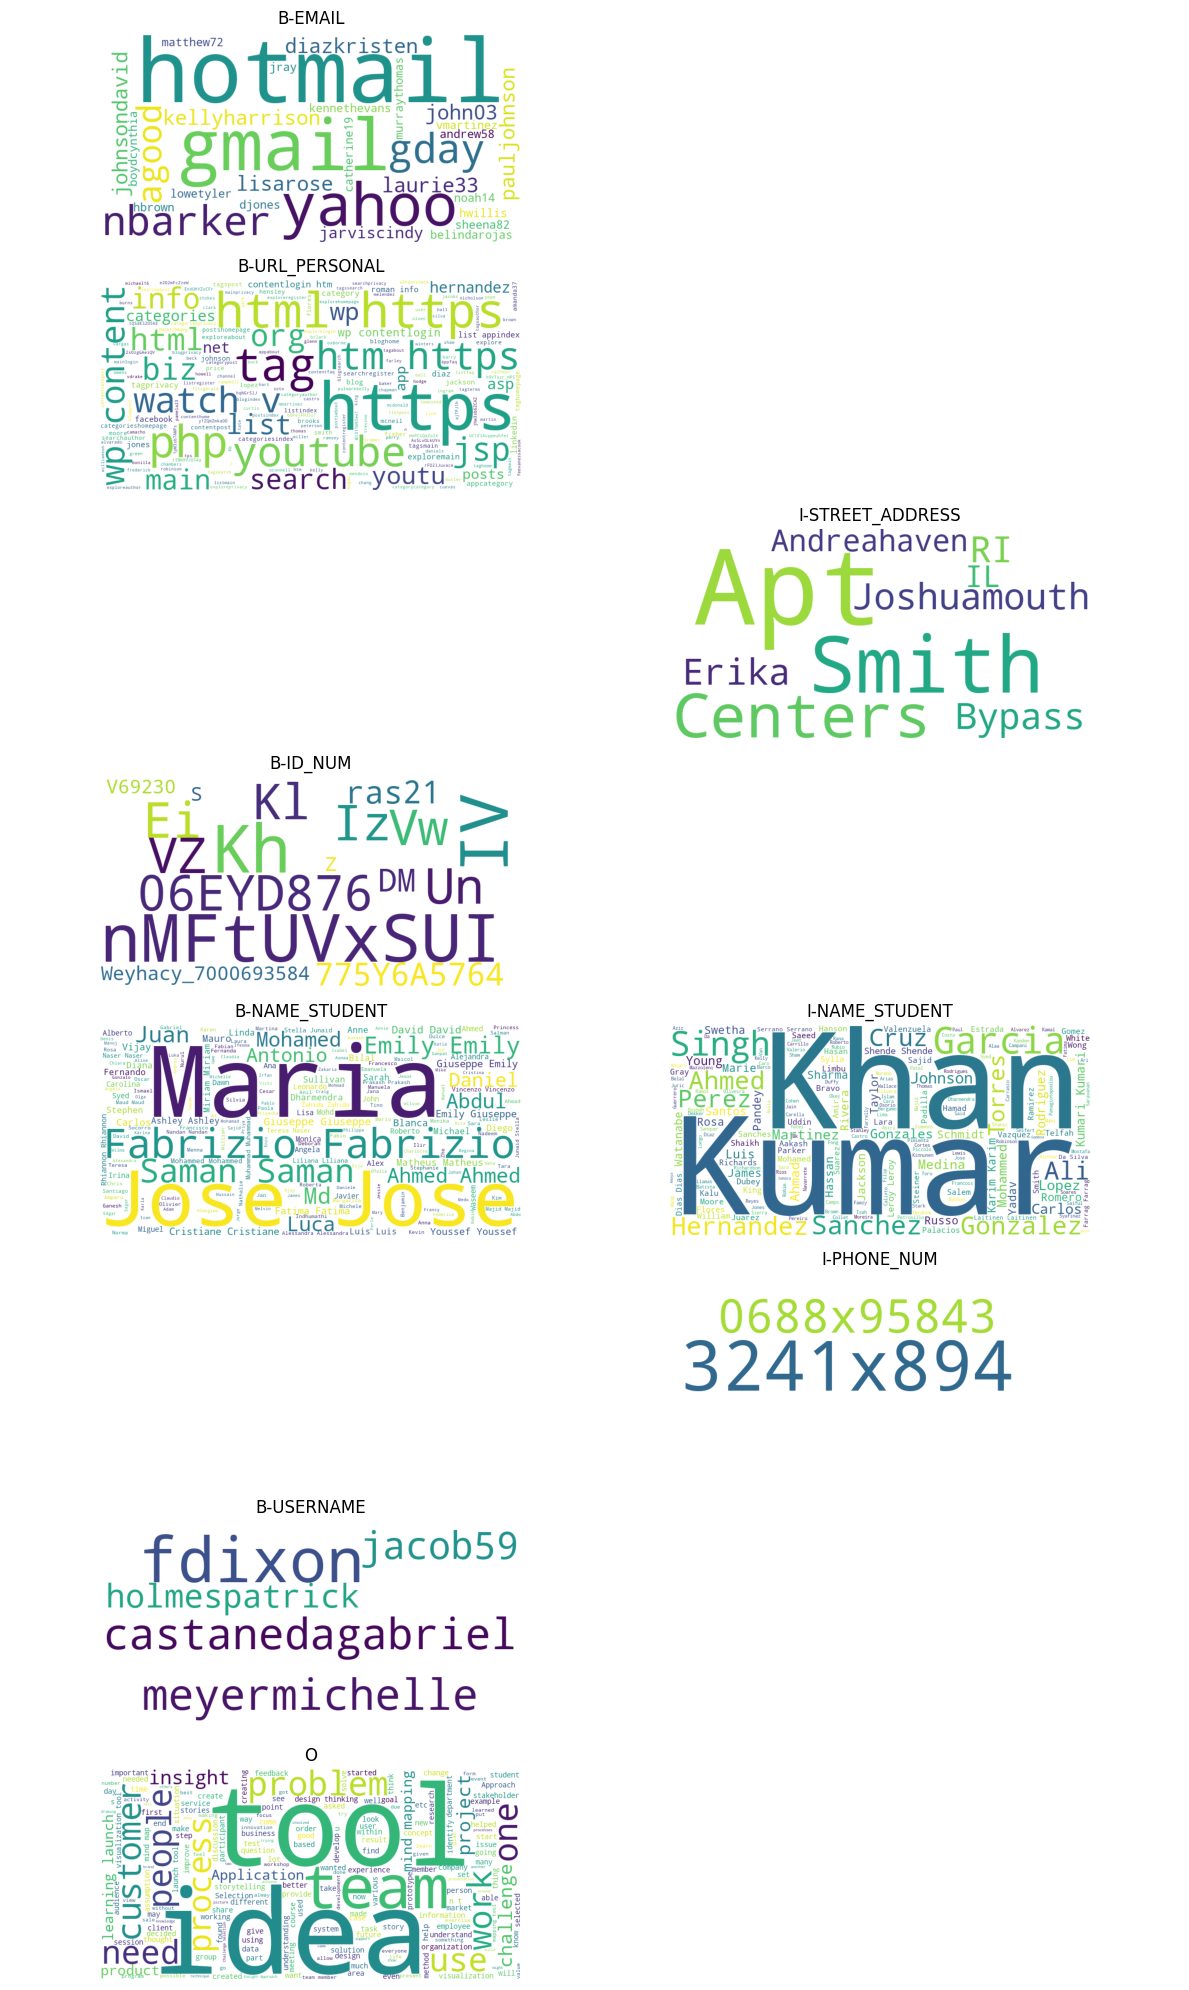

In [39]:
fig, axs = plt.subplots(8, 2, figsize=(12, 20))
#axs = axs.flatten()
for i, label in enumerate(labels_not_bio):
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    for j, bio_label in enumerate(notbio2bio[label]):
        try: 
            if len(label_2_word_list[bio_label]) <= 1:
                continue
            wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(label_2_word_list[bio_label]))
            axs[i, j].imshow(wordcloud)
            axs[i, j].set_title(bio_label)
        except:
            pass
plt.tight_layout()
plt.show()



Note:
- It is hard to use these plots, some within-label similarities might be more appropriate.

#### Word cloud for each label - disregarding the BIO format

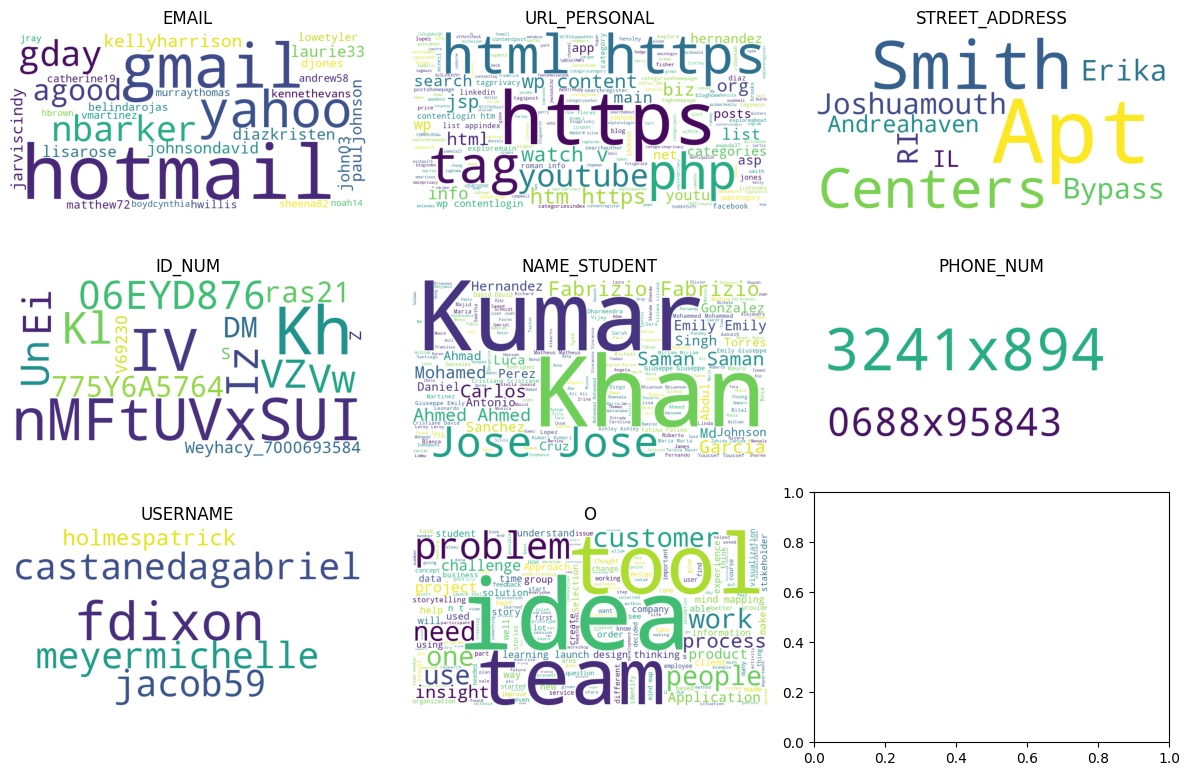

In [57]:
data = data2notbio(label_2_word_list, bio2notbio)
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
# NOTE: there are only 6 shown
axs = axs.flatten()
for i, label in enumerate(labels_not_bio):
    axs[i].axis('off')
    try: 
        if len(data[label]) <= 1:
            raise Exception
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(data[label]))
        axs[i].imshow(wordcloud)
        axs[i].set_title(label)
    except:
        pass
    #break
plt.tight_layout()
plt.show()



Note:
- EMAIL shows different domains
- NAME_STUDENT shows different ethnicities, let's investigate each group further instead.
- One would assume the STREET_NAME would be easy with words such as Street, Avenue, Road - however they do not seem to appear

---

## Qualitative label analysis


#### Three random samples from each class

In [78]:
data = data2notbio(label_2_word_list, bio2notbio)
for key, value in data.items():
    print(key)
    # sample 3
    n_samples = 2
    while n_samples > 0:
        try: 
            samples = random.sample(value, n_samples)
            n_samples = 0
        except:
            n_samples -= 1
    for sample in samples:
        print(f"    {sample}")

EMAIL
    gday@hotmail.com
    laurie33@yahoo.com
ID_NUM
    784372734211
    Kh:360595695159
NAME_STUDENT
    Fabrizio
    Kevin
PHONE_NUM
    820)913
    (
STREET_ADDRESS
    54207
    656
URL_PERSONAL
    https://www.linkedin.com/in/michael16
    http://mcdonald-pope.com/categorycategory.jsp
USERNAME
    jacob59
    castanedagabriel
O
    ’
    and


Note:


#### NAME_STUDENT

In [42]:
names = label_2_word_list['B-NAME_STUDENT'] + label_2_word_list['I-NAME_STUDENT']

Gender prediction

In [43]:
import gender_guesser.detector as gender
gender_detector = gender.Detector()

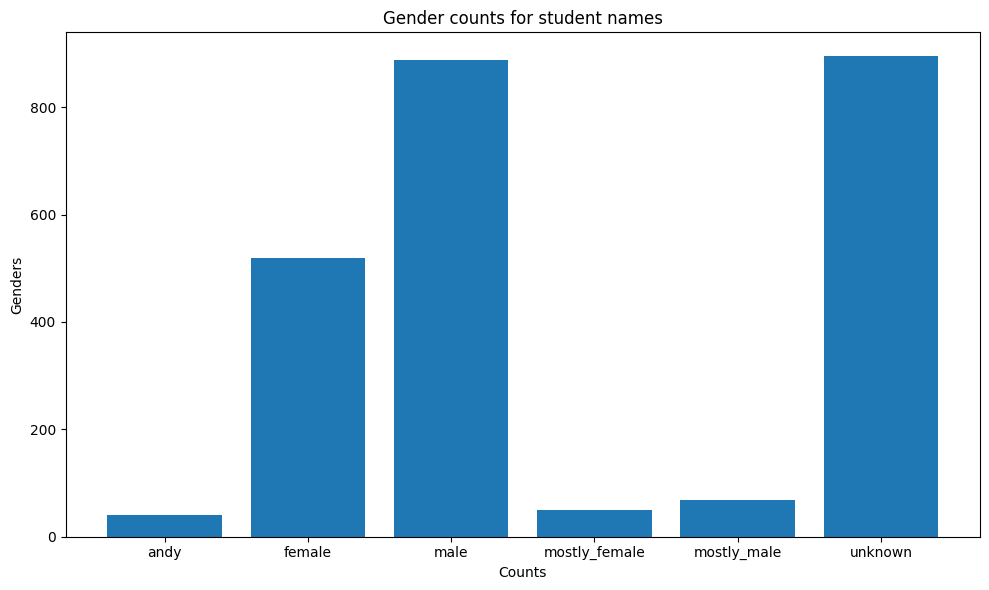

In [44]:
genders = [gender_detector.get_gender(name) for name in names]
uniques, counts = np.unique(genders, return_counts=True)

# barplot
plt.figure(figsize=(10, 6))
plt.bar(uniques, counts)
plt.xlabel("Counts")
plt.ylabel('Genders')
plt.title("Gender counts for student names")
plt.tight_layout()
plt.show()

Note:
- In general it seems to be biased towards make, however there are a lot of unknowns.

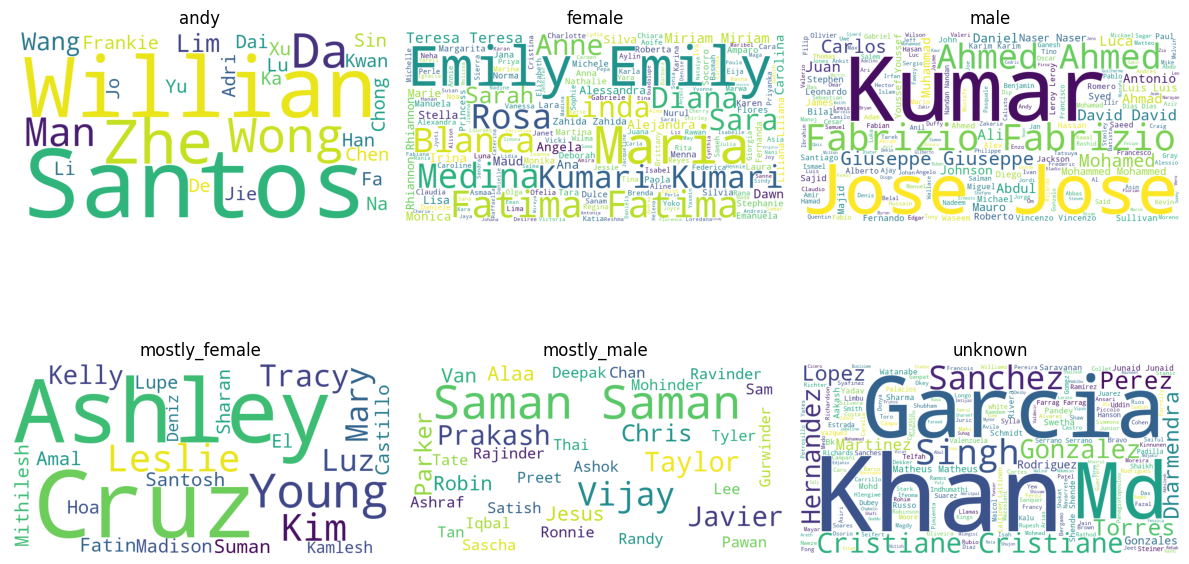

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# NOTE: there are only 6 shown
axs = axs.flatten()
dropped = 0
for i, _gender in enumerate(uniques):
    axs[i].axis('off')
    names_list = [name for (name, gender) in zip(names, genders) if gender == _gender]
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(names_list))
    axs[i].imshow(wordcloud)
    axs[i].set_title(_gender)
plt.tight_layout()
plt.show()



Note:
- Even though the texts are in english, have multitple ethnic backgrounds

Nationality prediction

In [59]:
from ethnicseer import EthnicClassifier;

ec = EthnicClassifier.load_pretrained_model();

In [60]:
nationalities = ec.classify_names(data['NAME_STUDENT'])
code_to_nationality = {
    'chi': 'Chinese',
    'eng': 'English',
    'frn': 'French',
    'ger': 'German',
    'ind': 'Indian',
    'ita': 'Italian',
    'jap': 'Japanese',
    'mea': 'Middle-Eastern',
    'rus': 'Russian',
    'spa': 'Spanish',
    'vie': 'Vietnamese',
    'kor': 'Korean'
}
print(len(code_to_nationality))

new_nationalities = [code_to_nationality[nationality] for nationality in nationalities]

12


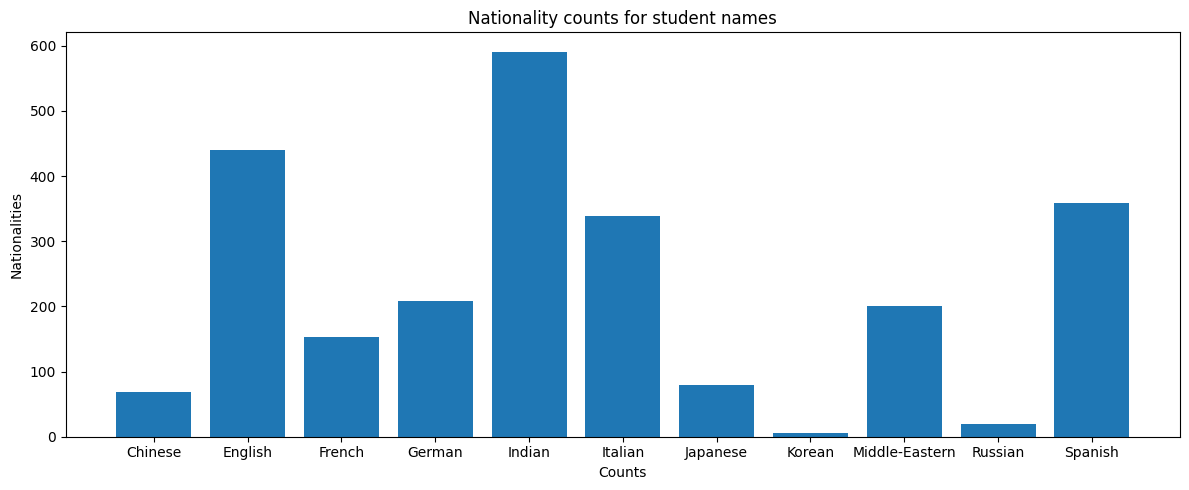

In [61]:
uniques, counts = np.unique(new_nationalities, return_counts=True)

# barplot
plt.figure(figsize=(12, 5))
plt.bar(uniques, counts)
plt.xlabel("Counts")
plt.ylabel('Nationalities')
plt.title("Nationality counts for student names")
plt.tight_layout()
plt.show()

Note:
- We see that most are English, Indian, Italian and Spanish

#### EMAIL

Domain

In [62]:
data = data2notbio(label_2_word_list, bio2notbio)

In [63]:
print(data['EMAIL'])

['djones@gmail.com', 'matthew72@hotmail.com', 'belindarojas@yahoo.com', 'kennethevans@hotmail.com', 'agood@gmail.com', 'agood@gmail.com', 'hwillis@gmail.com', 'kellyharrison@gmail.com', 'kellyharrison@gmail.com', 'lowetyler@hotmail.com', 'murraythomas@gmail.com', 'vmartinez@hotmail.com', 'sheena82@yahoo.com', 'nbarker@hotmail.com', 'nbarker@hotmail.com', 'nbarker@hotmail.com', 'johnsondavid@hotmail.com', 'johnsondavid@hotmail.com', 'catherine19@hotmail.com', 'john03@yahoo.com', 'john03@yahoo.com', 'lisarose@gmail.com', 'diazkristen@gmail.com', 'lisarose@gmail.com', 'diazkristen@gmail.com', 'andrew58@gmail.com', 'boydcynthia@yahoo.com', 'laurie33@yahoo.com', 'laurie33@yahoo.com', 'pauljohnson@hotmail.com', 'pauljohnson@hotmail.com', 'jarviscindy@hotmail.com', 'jarviscindy@hotmail.com', 'jray@hotmail.com', 'gday@hotmail.com', 'gday@hotmail.com', 'gday@hotmail.com', 'noah14@hotmail.com', 'hbrown@yahoo.com']


In [64]:
# extract domain
domains = [email.split("@")[-1] for email in data['EMAIL']]
len(domains)

39

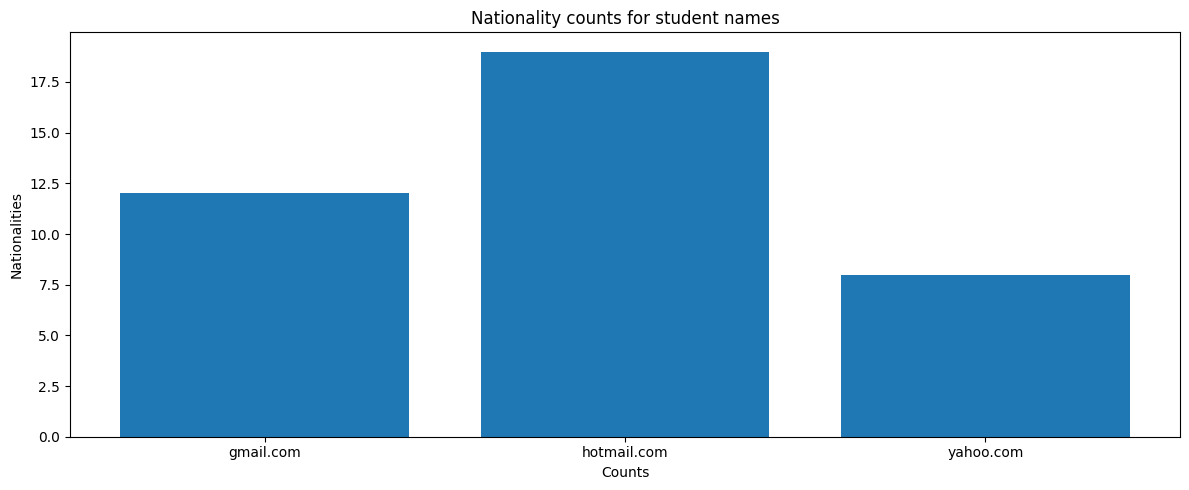

In [65]:
uniques, counts = np.unique(domains, return_counts=True)
# barplot
plt.figure(figsize=(12, 5))
plt.bar(uniques, counts)
plt.xlabel("Counts")
plt.ylabel('Nationalities')
plt.title("Nationality counts for student names")
plt.tight_layout()
plt.show()

Note:
- Seems like 'clean' data

In [67]:
# do all contain @?
_not = [e for e in uniques if "@" not in e]
print(len(_not))
_not

3


['gmail.com', 'hotmail.com', 'yahoo.com']

Note:
- Some are just the domain

#### Street


Suffix analysis: e.g., Street, Avenue, Road

Does it contain numbers?

#### Phone number

Land codes? the +?

In [68]:
data.keys()

dict_keys(['EMAIL', 'ID_NUM', 'NAME_STUDENT', 'PHONE_NUM', 'STREET_ADDRESS', 'URL_PERSONAL', 'USERNAME', 'O'])

---

## Label similarities

Maybe some tokenization, dimension reduction?

Note:
- probably: We see that the 'Name' is very correlated with alot of the features, signifying its' hierarchical importance
    - I.e. by first classifying a name, it could potentially contribute to classifying the rest of the labels

## Pattern investigation

Characteristic patterns
- All labels (general)
    - Pre/contextual words occurring before each label
    - Position within the text (e.g. in %)
    - Fast modules such as Spacy and Presidio for classification
- Name
    - Capitalization
- Email
    - Special characters like @
- etc

    

Finally create a dataset with these features and perform:
- a correlation analysis 
- a simple CART classification model